<a href="https://colab.research.google.com/github/reejungkim/SemanticSeg/blob/main/segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade transformers

In [ ]:
!unzip drone_dataset.zip

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug

In [ ]:
WIDTH = 512
HEIGHT = 512

In [ ]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "mask", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        
#         image = Image.open()
#         segmentation_map = Image.open()

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
transform = aug.Compose([
    aug.Flip(p=0.5)
])

In [ ]:
root_dir = 'drone_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 2100
Number of validation examples: 300


In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[1, 1, 1,  ..., 8, 8, 0],
        [1, 1, 1,  ..., 8, 8, 0],
        [1, 1, 1,  ..., 8, 8, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 0,  1,  2,  4,  8, 15, 22])

In [ ]:
mask = encoded_inputs["labels"].numpy()

In [ ]:
import matplotlib.pyplot as plt

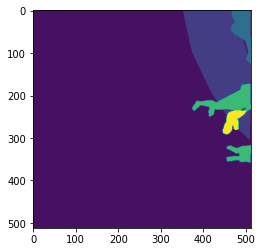

In [ ]:
plt.imshow(mask)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 512, 512])
labels torch.Size([4, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([4, 512, 512])

In [ ]:
classes = pd.read_csv('class_dict_seg.csv')['name']
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Downloading:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batc

In [ ]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


In [ ]:
for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8243746657598586         Train Loss: 0.6872287326483499         Val Pixel-wise accuracy: 0.8994070688883463         Val Loss: 0.34299485888332126
Epoch: 2


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9030302429199218         Train Loss: 0.3434400041046597         Val Pixel-wise accuracy: 0.9065401713053386         Val Loss: 0.31904059598843254
Epoch: 3


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.912936642964681         Train Loss: 0.29802674706493104         Val Pixel-wise accuracy: 0.9198766072591146         Val Loss: 0.2714970259865125
Epoch: 4


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9272599102201916         Train Loss: 0.24339506637482416         Val Pixel-wise accuracy: 0.9256576919555664         Val Loss: 0.24407623066256443
Epoch: 5


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9316724522908528         Train Loss: 0.2194917595280068         Val Pixel-wise accuracy: 0.9157005310058594         Val Loss: 0.267959307183822
Epoch: 6


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9356709852672759         Train Loss: 0.2044785230713231         Val Pixel-wise accuracy: 0.9276918411254883         Val Loss: 0.23669177802900473
Epoch: 7


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9410047004336403         Train Loss: 0.18338511196630342         Val Pixel-wise accuracy: 0.9293394978841146         Val Loss: 0.22906584572046995
Epoch: 8


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9342413784208752         Train Loss: 0.20687731340527535         Val Pixel-wise accuracy: 0.9185898590087891         Val Loss: 0.2757232645402352
Epoch: 9


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9440821856544132         Train Loss: 0.1733319698699883         Val Pixel-wise accuracy: 0.9308023961385091         Val Loss: 0.2322146426824232
Epoch: 10


  0%|          | 0/525 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9488954035441081         Train Loss: 0.1532916587697608         Val Pixel-wise accuracy: 0.9346396891276042         Val Loss: 0.2169866168188552


# Hugging Face Inference 🤗

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import math

In [ ]:
df = pd.read_csv('drone_dataset/class_dict_seg.csv')
classes = df['name']
palette = df[[' r', ' g', ' b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
root_dir = 'drone_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)
model = model.to(device)

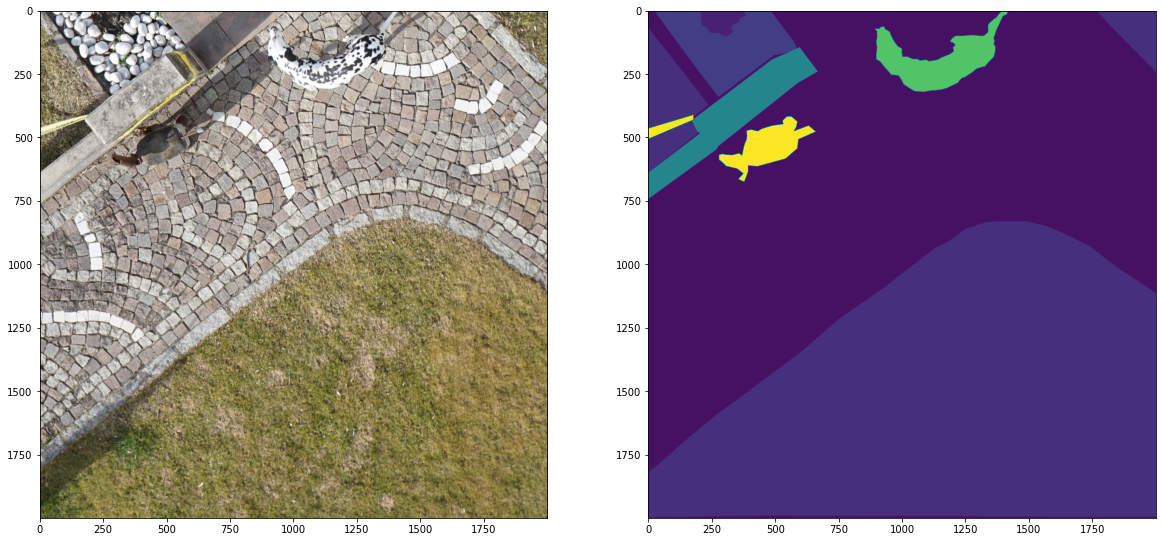

In [ ]:
image = cv2.imread('drone_dataset/images/test/532_5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread('drone_dataset/mask/test/532_5.png', 0)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 24, 128, 128])


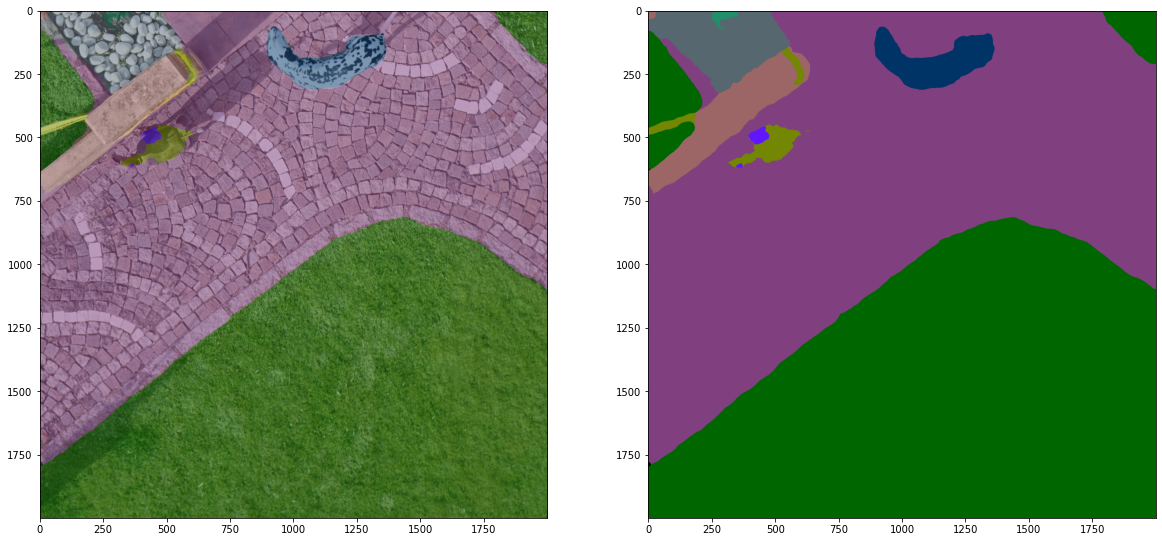

In [ ]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

In [ ]:
img.shape

(2000, 2000, 3)

In [ ]:
def crop_augment(img):
    HEIGHT, WIDTH = 2000, 2000

    vertical = math.ceil(img.shape[0] / HEIGHT)
    horizontal = math.ceil(img.shape[1] / WIDTH)
    start_v = 0
    count = 1
    data = {'images': [],
            'horizontal': horizontal,
            'vertical': vertical}
    for v in range(vertical):
        start_h = 0
        for h in range(horizontal):
            if start_h + WIDTH > img.shape[1]:
                start_h = start_h - ((start_h + WIDTH) - img.shape[1])
            if start_v + HEIGHT > img.shape[0]:
                start_v = start_v - ((start_v + HEIGHT) - img.shape[0])
            crop = img[start_v:start_v+HEIGHT, start_h:start_h+WIDTH]
            data['images'].append(crop)
            count += 1
            start_h += WIDTH
        start_v += HEIGHT

    return data

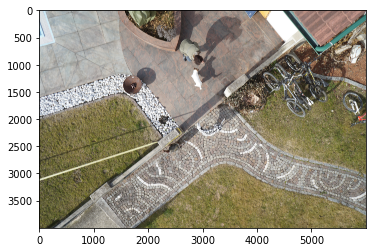

In [ ]:
image = cv2.imread('532.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

data = crop_augment(image)
plt.imshow(image)

In [ ]:
df = pd.read_csv('drone_dataset/class_dict_seg.csv')
classes = df['name']
palette = df[[' r', ' g', ' b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
root_dir = 'drone_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cpu")
model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)
model = model.to(device)

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
images = []
for img in data['images']:
    pixel_values = feature_extractor_inference(img, return_tensors="pt").pixel_values[0].numpy()
    images.append(pixel_values)
pixel_values = torch.tensor(np.array(images)).to(device)
print(pixel_values.shape)

torch.Size([6, 3, 512, 512])


In [ ]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)